Notas Clase:

SQL Transaccional vs OLAP

OLAP: para analytics.

Los árboles de decisión son buenos porque:

* tratan correctamente los datos faltantes

* no los afectan los outliers

* no los afecta la colinealidad de las variables

# SQL con clase

*The single biggest challenge to learning SQL programming is unlearning procedureal programming.*
-- Joe Celko

En este notebook, exploraremos diversos estilos y prácticas para escribir consultas SQL enfocadas en el análisis de datos. Las consultas analíticas se distinguen de las consultas convencionales en que están diseñadas específicamente para trabajar sobre grandes volúmenes de datos y tienden a ser más complejas.

## Setup

Primero vamos a configurar la notebook y definir las variables principales.

Instalamos los paquetes necesarios. Este paso se puede omitir si ya lo realizó en su entorno, sin embargo si usa **Colab** va a ser necesario ejecutarlo.

In [ ]:
%%bash
pip install duckdb
pip install jupysql
pip install duckdb-engine

Configuracion la extensión de %sql para el notebook, lo que nos va a permitir usar lenguaje SQL directamente sobre una celda

In [ ]:
import duckdb
import pandas as pd

%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:default:

Deploy Dash apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


Y finalmente cargamos el dataset en la base de datos

In [ ]:
# Connect to google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/DMEYF/' # Cargar el path de Google Drive donde se encuentre la base de datos competencia_01_crudo.csv
dataset_file = 'competencia_01_crudo.csv'

In [ ]:
%%sql
create or replace table competencia_01_crudo as
select
    *
from read_csv_auto("{{dataset_path + dataset_file}}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Success


## WITH



Un escenario común es necesitar realizar una consulta a no a una tabla, sino a otra consulta. Una forma tradicional de hacerlo es:
* Creando una tabla temporal con esa consulta
* Usando `selects from select`.

Esta necesidad es muy común, pero como todo en la vida hay peros.
- Crear una tabla en una base de datos que va a ser usada UNA SOLA VEZ ensucia los esquemas con un montón de tablas que no son útiles y además del desorden ocupan espacio innecesario
- El `select from select`, debe ser de las cosas peor vistas por los administradores de BBDD. Tienen sus razones técnicas, en general la recomendación es no usarlo a menos que uno conozca bien como funciona la base de datos por dentro, ya que hay casos donde terminan ocasionando muchos problemas

Y que hacer? bueno hay una clausula en **SQL** llamada `WITH`, que nos permite crear esas (plural) tablas para ser usadas en la **query** principal. Ejemplo si queremos comparar el valor de una variable con su promedio a través de todos los meses.


In [ ]:
%%sql
with promedios as (
    select
        numero_de_cliente
        , avg(mrentabilidad) as avg_mrentabilidad
    from competencia_01_crudo
    group by numero_de_cliente
) select
    cp.numero_de_cliente
    , cp.foto_mes
    , if(cp.mrentabilidad > p.avg_mrentabilidad, 'mayor', 'menor') as comparacion
from competencia_01_crudo cp
join promedios p using (numero_de_cliente)


,numero_de_cliente,foto_mes,comparacion
0,249221109,202101,mayor
1,249221468,202101,mayor
2,249223005,202101,menor
3,249228180,202101,mayor
4,249232117,202101,mayor
...,...,...,...
981941,1583120703,202106,menor
981942,1583776239,202106,mayor
981943,1588482879,202106,menor
981944,1589570953,202106,mayor


- Usar esa clausula tiene muchos beneficios, entre ellos sumar legibilidad de código y le permite al motor de **SQL** optimizar mejor, ya que entiende todo lo que se buscar hacer y planifica como resolverlo en el menor tiempo posible.

**NOTA**: Hay un tipo de tabla que se llaman temporales, que se borran solas una vez que uno se desconecta de la base de datos. Es una mejor alternativa frente al `CREATE`, sin embargo si la tabla que se esta creando se usa una sola vez es conveniente usar el `WITH` porque permite optimizar la ejecución. Si esa tabla va a ser usada mas de una vez dentro del proceso, las tablas temporales son la mejor opción.

# Funciones Analíticas

Las funciones analíticas en SQL son un conjunto de funciones que te permiten realizar cálculos avanzados sobre un conjunto de filas relacionadas dentro de una consulta conservando las filas individuales y calculando sobre ventanas de datos relacionadas.

Veamos un ejemplo para que quede más claro:

In [ ]:
%%sql
select
    numero_de_cliente
    , foto_mes
    , mrentabilidad
from competencia_01_crudo
where numero_de_cliente = 249221109
order by foto_mes

,numero_de_cliente,foto_mes,mrentabilidad
0,249221109,202101,1664.94
1,249221109,202102,1002.92
2,249221109,202103,769.74
3,249221109,202104,1532.79
4,249221109,202105,1804.14
5,249221109,202106,399.88


In [ ]:
%%sql
select
    numero_de_cliente
    , foto_mes
    , mrentabilidad
    , lead(mrentabilidad, 1) over (partition by numero_de_cliente order by foto_mes) as mrentabilidad_mas_1
    , lag(mrentabilidad, 1) over (partition by numero_de_cliente order by foto_mes) as mrentabilidad_menos_1
    , lead(mrentabilidad, 2) over (partition by numero_de_cliente order by foto_mes) as mrentabilidad_mas_2
    , lag(mrentabilidad, 2) over (partition by numero_de_cliente order by foto_mes) as mrentabilidad_menos_2
from competencia_01_crudo
where numero_de_cliente = 249221109
order by foto_mes



,numero_de_cliente,foto_mes,mrentabilidad,mrentabilidad_mas_1,mrentabilidad_menos_1,mrentabilidad_mas_2,mrentabilidad_menos_2
0,249221109,202101,1664.94,1002.92,NaN,769.74,NaN
1,249221109,202102,1002.92,769.74,1664.94,1532.79,NaN
2,249221109,202103,769.74,1532.79,1002.92,1804.14,1664.94
3,249221109,202104,1532.79,1804.14,769.74,399.88,1002.92
4,249221109,202105,1804.14,399.88,1532.79,NaN,769.74
5,249221109,202106,399.88,NaN,1804.14,NaN,1532.79


* Qué paso?
* ¿Cómo esta construyendo las nuevas variables?
* ¿ Nos puede ayudar a construir targets ?

¿Dondé puedo leer un poco más de esta magia negra? https://duckdb.org/docs/sql/window_functions.html

## Los casos raros

Que pasa con el cliente **304051318** y la foto **202103**


In [ ]:
%%sql
select
    numero_de_cliente
    , foto_mes
from competencia_01_crudo
where numero_de_cliente = 304051318
order by foto_mes

,numero_de_cliente,foto_mes
0,304051318,202101
1,304051318,202102
2,304051318,202104
3,304051318,202105
4,304051318,202106


* ¿Cuál debería ser la clase para cada periodo?

### Una pista

Podemos generar todas las posibles combinaciones de clientes y periodos de manera muy simple

In [ ]:
%%sql
with periodos as (
  select distinct foto_mes from competencia_01_crudo
), clientes as (
  select distinct numero_de_cliente from competencia_01_crudo
)
select numero_de_cliente, foto_mes from clientes cross join periodos
where numero_de_cliente = 304051318
order by foto_mes

,numero_de_cliente,foto_mes
0,304051318,202101
1,304051318,202102
2,304051318,202103
3,304051318,202104
4,304051318,202105
5,304051318,202106


Solo nos queda saber si estuvo o no el banco el cliente en ese periodo y armar el

In [ ]:
%%sql
with periodos as (
    select distinct foto_mes from competencia_01_crudo -- Esto también se puede hacer con secuencias
), clientes as (
    select distinct numero_de_cliente from competencia_01_crudo
), todo as (
    select numero_de_cliente, foto_mes from clientes cross join periodos
)
select
    t.numero_de_cliente
    , t.foto_mes
    , if(c.numero_de_cliente is null, 0, 1) as mes_0
from todo t
left join competencia_01_crudo c using (numero_de_cliente, foto_mes)
where t.numero_de_cliente = 304051318
order by foto_mes

,numero_de_cliente,foto_mes,mes_0
0,304051318,202101,1
1,304051318,202102,1
2,304051318,202103,0
3,304051318,202104,1
4,304051318,202105,1
5,304051318,202106,1


Antes de continuar, tomémonos un momento para reflexionar. Con todas estas piezas, ¿cómo podemos ensamblar el target?

Una vez que lo tengamos claro sobre el papel, proceda a completar el código que sigue.

Notas Clase:

If mes_2 = 1 => Continua

If Else Mes_1 = 1 => Baja+2

Else Baja+1

In [ ]:
%%sql
create or replace table competencia_01 as
with periodos as (
    select distinct foto_mes from competencia_01_crudo
), clientes as (
    select distinct numero_de_cliente from competencia_01_crudo
), todo as (
    select numero_de_cliente, foto_mes from clientes cross join periodos
), clase_ternaria as (
    select
        c.*
        , if(c.numero_de_cliente is null, 0, 1) as mes_0
        , lead(mes_0, 1) over (partition by t.numero_de_cliente order by foto_mes) as mes_1
        , lead(mes_0, 2) over (partition by t.numero_de_cliente order by foto_mes) as mes_2
--      , null as clase_ternaria -- Replazar null por la lógica que genera el target
        # , if (mes_2 = 1, 'CONTINUA',
        #       if (mes_1 = 1, 'BAJA+2', 'BAJA+1')), null
        , case
            when mes_2 is null or mes_1 is null then null
            when mes_2 = 1 then 'CONTINUA'
            when mes_1 = 1 then 'BAJA+2'
            else 'BAJA+1'
          end as clase_ternaria
    from todo t
    left join competencia_01_crudo c using (numero_de_cliente, foto_mes)
) select
  * EXCLUDE (mes_0, mes_1, mes_2)
from clase_ternaria
where mes_0 = 1

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Success


Observación: con esta lógica si un cliente es Baja+2 también va a aparecer como Baja+1

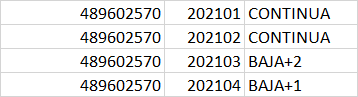

Revisamos que todo salga como esperamos

In [ ]:
%sql select count(*) from competencia_01

,count_star()
0,981946


Y vemos la cardinalidad de las clases por periodo

In [ ]:
%%sql
PIVOT competencia_01
on clase_ternaria
USING count(numero_de_cliente)
GROUP BY foto_mes

,foto_mes,BAJA+1,BAJA+2,CONTINUA
0,202101,635,785,160606
1,202102,785,1017,160844
2,202103,1020,981,161684
3,202104,982,1189,161919
4,202105,0,0,0
5,202106,0,0,0


Y finalmente almacenamos el nuevo dataset para ser usado a continuación

In [ ]:
%%sql COPY competencia_01 TO '{{dataset_path}}competencia_01.csv' (FORMAT CSV, HEADER)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Success



## El pato del amor

DuckDB no es una base de datos SQL estándar; su sintaxis moderna facilita significativamente la escritura de consultas. A continuación, te menciono algunas características destacadas:

+ Uso de variables: En DuckDB, no es necesario reescribir las variables; puedes utilizar tus variables una vez definidas, lo que simplifica el código.

+ Función IF: DuckDB soporta la función IF(condición, valor_si_verdadero, valor_si_falso), lo que hace que tu código sea más claro y legible en comparación con el uso de CASE WHEN.

+ Exclusión de campos: Puedes utilizar SELECT * EXCLUDE(field1, ...) para excluir campos específicos de la lista de selección, lo que ahorra tiempo y esfuerzo.

+ Alias en cláusulas: Es posible utilizar alias en las cláusulas WHERE, GROUP BY y HAVING, lo que añade flexibilidad a la escritura de consultas.

+ Uso de alias en cálculos: DuckDB permite el uso de alias dentro del cálculo de otros campos, facilitando la manipulación y transformación de datos en una consulta.

Estas son solo algunas de las capacidades que hacen de DuckDB una herramienta poderosa. Te recomiendo leer la documentación y el blog oficial para explorar más a fondo su potencial.